# Statistical Analysis

**RankEval** provides the following statistical analysis tools: *i)* Fisher's randomization test for statistical significance, and *ii)* bias/variance decomposition of the error.

In [1]:
# import common libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import math
from matplotlib import pyplot as plt

## Statistical Significance

According to the work by *M.D. Smucker, J. Allan, B. Carterette, "A Comparison of Statistical Significance Tests for Information Retrieval Evaluation", CIKM 2007*, **Fisher's randomization test** is the most appropriate statistical test to evaluate wheter two rankers differ significantly.

We first shortly describe the test. The null hypthesis is that the two given rankers A and B are indentical: an underlying ranker R is asked to produce two rankings for each given query  and these two rankings are randomly labeled as ranker A or ranker B. The goal of the test is to measure the probability that the observed performance gap between ranker A and B is due to a random labeling.

Under the null hypthesis, every permutation of the labelling is equally probable. If we enumerate all the possible A-B labelings, and we measure the corresponding quality gap, we have that:
 - the *one-sided p-value* is given by the fraction of times the quality difference is larger than the originally observed difference;
 - the *two-sided p-value* is given by the fraction of times the resulting quality *absolute difference* is larger than the originally observed difference.

Since the number of permutations is exponential in the number of queries, a large number of random permutations is used.

##### Import RankEval statistical significance tools

In [2]:
from rankeval.model import RTEnsemble
from rankeval.dataset import Dataset
from rankeval.metrics import NDCG
from rankeval.metrics import Precision
from rankeval.analysis.statistical import statistical_significance

from rankeval.visualization.utils import xarray3D_to_dataframe

##### Load models and data from file

In [3]:
dataset_file = "/Users/claudio/docs/LAVORO/coding/ltr/QuickScorer/debug_data/msn1.fold1.test.5k.txt"
model_file = "/Users/claudio/docs/LAVORO/coding/ltr/QuickScorer/debug_data/model.lmart.msn1.xml"
model_a = RTEnsemble(model_file, name="L-Mart.100T")
model_b = RTEnsemble(model_file, name="L-Mart-2.100T")
dataset_a = Dataset.load(dataset_file, name="msn1")
dataset_b = Dataset.load(dataset_file, name="msn2")

##### Run the Fisher's Randomization test

The `statistical_significance` test between a two rankers can be run on a list of datasets and for a list of IR quality metrics. The function returns both the one-sided and two-sided p-values.

In [4]:
stat_sig = statistical_significance(datasets=[dataset_a, dataset_b],
                                    model_a=model_a, model_b=model_b, 
                                    metrics=[NDCG(cutoff=10), NDCG(cutoff=50), Precision(cutoff=10)],
                                    n_perm=100000 )

In [5]:
xarray3D_to_dataframe(stat_sig)

p-value
msn1 NDCG@10           one-sided      1.0
                       two-sided      1.0
     NDCG@50           one-sided      1.0
                       two-sided      1.0
     Precision@10[>=1] one-sided      1.0
                       two-sided      1.0
msn2 NDCG@10           one-sided      1.0
                       two-sided      1.0
     NDCG@50           one-sided      1.0
                       two-sided      1.0
     Precision@10[>=1] one-sided      1.0
                       two-sided      1.0

# Bias-Variance

... on going ...

by reading a few papers [cite] the methodology is as follows...

The Loss of a Algorithm (not of a model!) can be decomposed in:
$$L(A) = Bias(A) + Variance(A) + Noise(A)$$
where:
 - Bias is how far is the model from the prediction
 - Variance is how sensitive (how changes) the prediction with different training sets (overfitting)
 - Noise is the irreducible error in the dataset (learner independent)

Given a dataset $D$, given a number of iteration $l$, we need to produce $l$ score predictions
for each element in $D$ with $l$ different models. If the loss function $L$ is MSE then everything is clear.
If the loss function is NDCG, no previous work.

  0. Shuffle $D$ and create two halves $D_1$ and $D_2$ (this should be query-aware with NDCG)
  0. learn a model from $D_1$ and apply it to $D_2$
  0. learn a model from $D_2$ and apply it to $D_1$
  0. store the scores produced so far
  0. Repeat all of the above $l$ times
  0. for each document/query compute the average prediction by averagin the $l$ stored so far (for ranking this is actually not defined, we may average predictions and then rank accordingly)
  0. Bias of a query/document is computed as the loss between the ideal prediction and the average prediction
  0. Average above for every query/document to obtain final Bias
  0. Variance of a query/document is computed as the average loss between the average prediction and every of the $l$ predictions
  0. Average above for every query/document to obtain final Variance
 
Usually Noise is assumed to be 0 as it is impossible to estimated it.
As a consequence, ometimes Variance is defined as $L(A)-Bias(A)$.

In every work, $L(A)$ should be equal to $Bias(A) + Variance(A)$. Is this true for NDCG? probably not ...

In principle, we may provide just the Loss and the Bias, and let the user compute variance by difference.

We might probalby solve the ranking problem, by saying that L is not 1-NDCG, but rather (1-NDCG)^2

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from rankeval.core.dataset import Dataset
from rankeval.core.metrics import NDCG
from rankeval.core.metrics.rmse import RMSE
from rankeval.core.metrics.metric import Metric
from rankeval.analysis.statistical import bias_variance
import numpy as np
import math
import lightgbm
#from __future__ import print_function

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
dataset = Dataset.load("/Users/claudio/docs/LAVORO/coding/ltr/QuickScorer/debug_data/msn1.fold1.test.5k.txt", name="msn1")

In [3]:
def lgbm_algo(train_X, train_Y, train_q, test_X):
    params = {'num_leaves': 128, 'objective':'lambdarank',
             'learning_rate': 0.01, 'max_bin': 1024}

    training = lightgbm.Dataset(data=train_X, label=train_Y, group=train_q)
    
    bst = lightgbm.train(params, training, num_boost_round=10)
    
    # check the number of trees and other params is correct
    # print ( len(bst.dump_model()[u'tree_info']) )
    
    return bst.predict(test_X)

In [15]:
bias_variance(dataset, algo=lgbm_algo, metric="mse", L=5, k=3, verbose=2)

 + Dataset scoring 0 of 5
 - Processing fold 0 of 3
 - Processing fold 1 of 3
 - Processing fold 2 of 3
 + Dataset scoring 1 of 5
 - Processing fold 0 of 3
 - Processing fold 1 of 3
 - Processing fold 2 of 3
 + Dataset scoring 2 of 5
 - Processing fold 0 of 3
 - Processing fold 1 of 3
 - Processing fold 2 of 3
 + Dataset scoring 3 of 5
 - Processing fold 0 of 3
 - Processing fold 1 of 3
 - Processing fold 2 of 3
 + Dataset scoring 4 of 5
 - Processing fold 0 of 3
 - Processing fold 1 of 3
 - Processing fold 2 of 3


(1.0553246, 1.0552039, 0.00012066727)

In [10]:
a = bias_variance(dataset, algo=lgbm_algo, metric=NDCG(cutoff=10), L=10, k=2)

(' + Dataset scoring', 0, 'of', 10)
(' + Dataset scoring', 1, 'of', 10)
(' + Dataset scoring', 2, 'of', 10)
(' + Dataset scoring', 3, 'of', 10)
(' + Dataset scoring', 4, 'of', 10)
(' + Dataset scoring', 5, 'of', 10)
(' + Dataset scoring', 6, 'of', 10)
(' + Dataset scoring', 7, 'of', 10)
(' + Dataset scoring', 8, 'of', 10)
(' + Dataset scoring', 9, 'of', 10)


In [8]:
print (a)

(0.42988306, 0.41835901, 0.011524014)


In [9]:
m = NDCG(cutoff=10)

In [3]:
params = {'num_leaves': 128, #'objective':'lambdarank',
         'learning_rate': 0.01, 'max_bin': 1024}

training = lightgbm.Dataset(data=dataset.X, label=dataset.y)
    
bst = lightgbm.train(params, training, num_boost_round=10)


In [6]:
print lightgbm.plot_importance.__doc__


Plot model feature importances.

    Parameters
    ----------
    booster : Booster or LGBMModel
        Booster or LGBMModel instance
    ax : matplotlib Axes
        Target axes instance. If None, new figure and axes will be created.
    height : float
        Bar height, passed to ax.barh()
    xlim : tuple of 2 elements
        Tuple passed to axes.xlim()
    ylim : tuple of 2 elements
        Tuple passed to axes.ylim()
    title : str
        Axes title. Pass None to disable.
    xlabel : str
        X axis title label. Pass None to disable.
    ylabel : str
        Y axis title label. Pass None to disable.
    importance_type : str
        How the importance is calculated: "split" or "gain"
        "split" is the number of times a feature is used in a model
        "gain" is the total gain of splits which use the feature
    max_num_features : int
        Max number of top features displayed on plot.
        If None or smaller than 1, all features will be displayed.
    ignore_

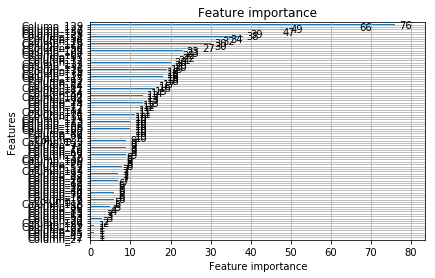

In [4]:
def prova(fig):
    ax = fig.add_subplot(1, 1, 1)
    ax.plot([1,2,3,4,5])
    return ax

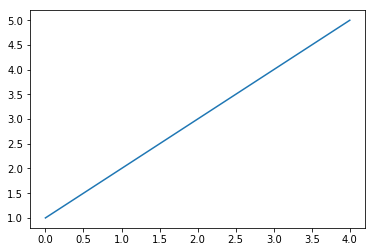

In [5]:
fig = plt.figure()
ax = prova(fig)

In [6]:
ax.set_title("title")

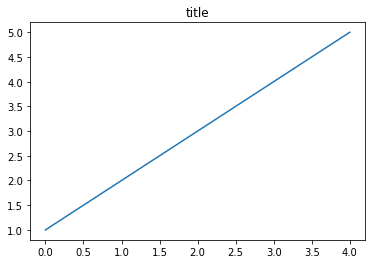

In [10]:
fig

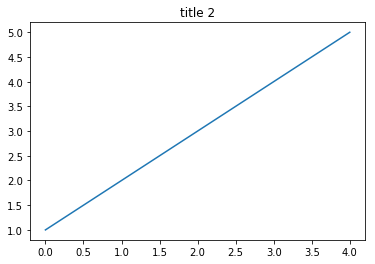

In [11]:
ax.set_title("title 2")
fig

In [12]:
ax2 = fig.axes

In [13]:
print len(ax2)

1


In [14]:
ax2[0].set_xlabel("xxxxx")

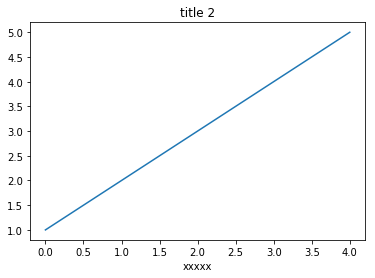

In [15]:
fig